# preset value

In [29]:
!rm - rf logs

rm: cannot remove '-': No such file or directory
rm: cannot remove 'rf': No such file or directory
rm: cannot remove 'logs': Is a directory


In [30]:
# 调试bug
# %xmode Verbose
%xmode Plain

Exception reporting mode: Plain


# Import Lib

In [31]:
from __future__ import print_function
import time
import math
from IPython.display import HTML
from tqdm.notebook import tqdm
import shutil
import imageio
import logging
from tensorboardX import SummaryWriter
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.nn as nn
import torch
import random
import os
import argparse
%matplotlib inline

# setting parameters

## setting net 

In [32]:
# Setting parameters
workers = 2
# Number of training epochs
current_epoch = 0
current_iteration = 0
num_epochs = 50
each_epoch_logging_interval = 200
checkpoint_save_interval = 50
# seed
seed = 999
# data contribute
dataroot = '../MNIST/'
batch_size = 128
image_size = 28
# label class
n_class = 10
# Number of channels
nc = 1
# Latent vector (i.e. size of generator input)
nz = 62
n_dis = 10
n_con = 2
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Learning rate for optimizers
lr_G = 1e-3
lr_D = 2e-4
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999
cudnn.benchmark = True
# Save and load model file
checkpoint_dir = './checkpoint_dir/'
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## setting logging and tensorboard

In [33]:
if not os.path.exists('./logs/'):
    os.makedirs('./logs/')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# set logging
logging.getLogger().setLevel(logging.INFO)
fhandler = logging.FileHandler('./logs/DCGAN.log')
logger = logging.getLogger('DCGAN')
logger.addHandler(fhandler)

# tensorboard
writer = SummaryWriter('./logs/Tensorboard_DCGAN')

## setting seed

In [34]:
def seed_everything(seed=999):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(seed=seed)

# Utils

## weights_init

In [35]:
def weights_init(m):
    '''
    init model paramters
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## AverageMeter

In [36]:
class AverageMeter:
    '''
    record the value
    '''

    def __init__(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count

    @property
    def val(self):
        return self.avg

## transform_onehot

In [37]:
def transform_onehot(ori_list, onehot_size=2):
    '''
    ori_list type is Tensor
    '''
    batch_size = len(ori_list)
    onehot = torch.zeros(batch_size, onehot_size)
    index_LongTensor = ori_list.type(torch.LongTensor).unsqueeze(1)
    onehot_list = onehot.scatter_(1, index_LongTensor, 1)
    return onehot_list

## noise sample

In [38]:
def noise_sample(batch_size=batch_size, number_dis=1,  n_dis=10, n_con=2, nz=nz, device=device):
    """
    Sample random noise vector for training.

    INPUT
    -------- 
    number_dis : Number of discrete latent code. EX.number_dis=3 [0...01，0...01，0...01]
    n_dis : Dimension of discrete latent code.
    n_con : Number of continuous latent code.
    nz : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    nosie_ = torch.randn(batch_size, nz, 1, 1)
    # construct the discrete data
    dis = []
    dis_id = []
    for i in range(number_dis):
        temp_dis_id = torch.randint(0, n_dis, size=(batch_size, ))
        temp_dis = transform_onehot(temp_dis_id, onehot_size=n_dis)
        dis_id.append(temp_dis_id)
        dis.append(temp_dis)
    dis_cat_ = torch.cat(dis, 1).unsqueeze(2).unsqueeze(3)
    dis_id_cat_ = torch.cat(dis_id, 0)
    # construct the continue data
    con_ = torch.rand(batch_size, n_con, 1, 1) * 2 - 1
    # construct the nosie data
    code_ = torch.cat([dis_cat_, con_], dim=1)

    return nosie_.to(device), code_.to(device)


nosie, code = noise_sample()
c_discrete_label = torch.max(code[:, :-2], 1)[1].view(-1, 1)
nosie.shape, code.shape, c_discrete_label.shape

(torch.Size([128, 62, 1, 1]),
 torch.Size([128, 12, 1, 1]),
 torch.Size([128, 1]))

## log_gaussian

In [39]:
def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)

# dataset

## load data

1.从api中获取数据集  

    if not os.path.exists('../cifar10/'):
        os.makedirs('../cifar10/')
        
    dataset = datasets.CIFAR10(root="../cifar10/",
                           train=True,
                           transform=transform,
                           target_transform=None,
                           download=True)

2.其他数据集设置(从文件夹中读取文件)  
    
    dataset = datasets.ImageFolder(root=dataroot, transform=transform)  

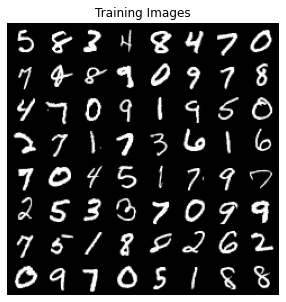

In [40]:
def get_loader():
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ])
    #################################################
    if not os.path.exists(dataroot):
        os.makedirs(dataroot)

    dataset = datasets.MNIST(root=dataroot,
                             train=True,
                             transform=transform,
                             target_transform=None,
                             download=True,)
    #################################################
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             num_workers=workers,)
    return dataloader


def check_dataloader(dataloader):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(real_batch[0].to(device)[:64],
                             padding=2,
                             normalize=True).cpu(), (1, 2, 0)))


dataloader = get_loader()
check_dataloader(dataloader)

# model

## Generator

In [41]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(nz + n_dis + n_con, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7 * 7 * 128),
            nn.BatchNorm1d(7 * 7 * 128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(  # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(  # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z, c):
        z = z.view(z.size(0), -1)
        c = c.view(c.size(0), -1)
        noise = torch.cat((z, c), 1)
        x_ = self.layer1(noise)
        x_ = self.layer2(x_)
        x_ = x_.view(x_.size(0), 128, 7, 7)
        x_ = self.layer3(x_)
        x_ = self.layer4(x_)
        return x_


def test_Generator(G):
    inp, code = noise_sample()
    print('{} {}'.format(inp.shape, code.shape))
    out = G(inp.to('cpu'), code.to('cpu'))
    print(out.shape)


G = Generator()
G = G.apply(weights_init)
test_Generator(G)
G

torch.Size([128, 62, 1, 1]) torch.Size([128, 12, 1, 1])
torch.Size([128, 1, 28, 28])


Generator(
  (layer1): Sequential(
    (0): Linear(in_features=74, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=6272, bias=True)
    (1): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)

## Discriminator

In [42]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(  # 28 -> 14
            nn.Conv2d(nc, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(  # 14 -> 7
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3_1 = nn.Sequential(  #
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.layer3_2 = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer3_1(y_)
        d = self.layer3_2(y_)  # Real / Fake
        return d, y_  # return with top layer features for Q


def test_Discriminator():
    inp = torch.randn(batch_size, nc, image_size, image_size) * 2 - 1
    print('{}'.format(inp.shape))
    d, y_ = D(inp)
    print('{}  {}'.format(d.shape, y_.shape))


D = Discriminator()
D = D.apply(weights_init)
test_Discriminator()
D

torch.Size([128, 1, 28, 28])
torch.Size([128, 1])  torch.Size([128, 1024])


Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (layer3_1): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (layer3_2): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Q net

In [43]:
class Qrator(nn.Module):
    """
        Regularization Network for increasing Mutual Information
    """

    def __init__(self):
        super(Qrator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 14),
        )

    def forward(self, x):
        # Seperate code
        c = self.fc(x)
        c_discrete = torch.softmax(c[:, :10], dim=-1)  # Digit Label {0~9}
        c_mu = c[:, 10:12]  # mu & var of Rotation & Thickness
        c_var = c[:, 12:14].exp()  # mu & var of Rotation & Thickness
        return c_discrete, c_mu, c_var


def test_Qrator():
    inp = torch.randn(batch_size, 1024) * 2 - 1
    print('{}'.format(inp.shape))
    c_discrete, c_mu, c_var = Q(inp)
    print('{}  {} {} '.format(c_discrete.shape, c_mu.shape, c_var.shape))


Q = Qrator()
Q = Q.apply(weights_init)
test_Qrator()
Q

torch.Size([128, 1024])
torch.Size([128, 10])  torch.Size([128, 2]) torch.Size([128, 2]) 


Qrator(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=128, out_features=14, bias=True)
  )
)

## load and save model method

### save_checkpoint

In [44]:
def save_checkpoint(epoch, file_name='checkpoint.pth.tar'):
    state = {
        'current_epoch': epoch,
        'current_iteration': current_iteration,
        'fixed_noise': fixed_noise,
        'seed': seed,
        'G_state_dict': G.state_dict(),
        'Q_state_dict': Q.state_dict(),
        'G_optimizer': optimizerG.state_dict(),
        'D_state_dict': D.state_dict(),
        'D_optimizer': optimizerD.state_dict(),
    }
    path_file_name = ''
    if file_name == 'checkpoint.pth.tar':
        file_name = 'checkpoint_epoch_{}.pth.tar'.format(str(epoch))
        path_file_name = checkpoint_dir + file_name
    else:
        path_file_name = checkpoint_dir + file_name
    torch.save(state, path_file_name)


# save_checkpoint(epoch=10,file_name= 'checkpoint_result_epoch_{}.pth.tar'.format(str(10)))

### load_checkpoint

In [45]:
def load_checkpoint(path_file_name):
    # logging
    logger.info("Loading checkpoint '{}'".format(path_file_name))
    try:
        checkpoint = torch.load(path_file_name,
                                map_location=torch.device(device))
        # read checkpoint
        global current_epoch, current_iteration, fixed_noise, seed, netG, optimizerG, netD, optimizerD
        current_epoch = checkpoint['current_epoch']
        current_iteration = checkpoint['current_iteration']
        fixed_noise = checkpoint['fixed_noise']
        seed = checkpoint['seed']
        G.load_state_dict(checkpoint['G_state_dict'])
        Q.load_state_dict(checkpoint['Q_state_dict'])
        optimizerG.load_state_dict(checkpoint['G_optimizer'])
        D.load_state_dict(checkpoint['D_state_dict'])
        optimizerD.load_state_dict(checkpoint['D_optimizer'])
        # logging
        logger.info(
            "Checkpoint loaded successfully from '{}' at (epoch {}) at (iteration {})\n"
            .format(path_file_name, checkpoint['current_epoch'],
                    checkpoint['current_iteration']))
        print(
            "Checkpoint loaded successfully from '{}' at (epoch {}) at (iteration {})\n"
            .format(path_file_name, checkpoint['current_epoch'],
                    checkpoint['current_iteration']))
    except OSError as e:
        logger.info("No checkpoint exists from '{}'. Skipping...".format(
            './checkpoint/'))
        logger.info("**First time to train**")
        print("**First time to train**")


# load_checkpoint(checkpoint_dir + 'checkpoint_epoch_10.pth.tar')

# run

## Init model module

In [46]:
# copy net to device
G = G.to(device)
D = D.to(device)
Q = Q.to(device)

bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

fixed_noise, fixed_code = noise_sample()

real_label = torch.ones([batch_size, 1]).to(device)
fake_label = torch.zeros([batch_size, 1]).to(device)

# Setup Adam optimizers for bosssssth G and D
optimizerD = optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))
optimizerG = optim.Adam([{
    'params': G.parameters()
}, {
    'params': Q.parameters()
}],
    lr=lr_G,
    betas=(beta1, beta2))
# schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=3, gamma=0.9)
# schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=3, gamma=0.9)

## train_one_step

In [47]:
def train_one_step(epoch):
    global current_iteration
    tqdm_batch = tqdm(dataloader,
                      total=len(dataloader),
                      desc="epoch-{}-".format(epoch))
    for i, data in enumerate(tqdm_batch):
        # prepare the data
        x_ = data[0].to(device)
        ############################
        # Train D
        x_output, _ = D(x_)
        loss_D_real = bce_loss(x_output, real_label)

        z, c = noise_sample()
        z_outputs, _ = D(G(z, c))
        loss_D_fake = bce_loss(z_outputs, fake_label)

        loss_D = (loss_D_fake + loss_D_real)

        optimizerD.zero_grad()
        loss_D.backward()
        optimizerD.step()
        ############################
        # Train G
        z, c = noise_sample()
        c_discrete_label = torch.max(code[:, :-2], 1)[1].view(-1, 1)
        z_outputs, features = D(G(z, c))  # (B,1), (B,10), (B,4)
        c_discrete_out, c_mu, c_var = Q(features)

        loss_G = bce_loss(z_outputs, real_label)
        loss_Q_discrete = ce_loss(c_discrete_out, c_discrete_label.view(-1))
        loss_Q_continuous = - \
            torch.mean(torch.sum(log_gaussian(c[:, -2:], c_mu, c_var), 1))
        loss_mutual_info = loss_Q_continuous + loss_Q_discrete*0.1
        loss_GnQ = loss_G + loss_mutual_info

        optimizerG.zero_grad()
        loss_GnQ.backward()
        optimizerG.step()
        ###########################
        # counter increase
        current_iteration += 1
        ###########################
        # Output training stats
        if i % each_epoch_logging_interval == 0:
            # logging
            logger.info(
                '[%d/%d][%d/%d]\tLoss_D: %.4f\tloss_GnQ: %.4f'
                % (epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_GnQ.item())
            )
            print(
                '[%d/%d][%d/%d]\tLoss_D: %.4f\tloss_GnQ: %.4f'
                % (epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_GnQ.item())
            )
            # tensorboard
            writer.add_scalars('Train/loss_all', {
                'epoch_loss_G': loss_GnQ.item(),
                'epoch_loss_D': loss_D.item(),
            }, current_iteration)
            writer.add_scalars('Train/Q', {
                'loss_mutual_info': loss_mutual_info.item(),
                'loss_Q_discrete': loss_Q_discrete.item(),
                'loss_Q_continuous': loss_Q_continuous.item(),
            }, current_iteration)

## valid

In [48]:
def valid(epoch):
    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake = G(fixed_noise, fixed_code)
        output, _ = D(fake)
        loss_G = bce_loss(output, real_label)
        # check image
        fake_image_grid = vutils.make_grid(fake[:8].detach().cpu(),
                                           padding=2,
                                           normalize=True)
        plt.imshow(np.transpose(fake_image_grid, [1, 2, 0]))
        plt.show()
        # tensorboard
        writer.add_scalars('Valid/loss_G', {
            'loss_G': loss_G.item(),
        }, epoch)
        fake_image_grid = vutils.make_grid(fake.detach().cpu(),
                                           padding=2,
                                           normalize=True)
        writer.add_image('generated_image', fake_image_grid, epoch)

## load pretrain model

从pretrain model中加载参数  

    state = torch.load(f=f, map_location=torch.device(device))
    agent.netG.load_state_dict(state['G_state_dict'])
    agent.netE.load_state_dict(state['netE_state_dict'])
    agent.fixed_noise = state['fixed_noise']

In [49]:
path_file_name = './checkpoint_result_epoch_49.pth.tar'
load_checkpoint(path_file_name=path_file_name)

Checkpoint loaded successfully from './checkpoint_result_epoch_49.pth.tar' at (epoch 49) at (iteration 23400)



## main

In [50]:
logger.info("Starting Training Loop...")
start_time = time.perf_counter()
#####################
# main
for epoch in range(current_epoch, num_epochs):
    #####################
    #train and valid
    train_one_step(epoch)
    valid(epoch)
    #####################
#     schedulerG.step()
#     schedulerD.step()
    #####################
    # tensorboard paramters
    writer.add_scalar('lr_netG', optimizerG.param_groups[0]['lr'], epoch)
    writer.add_scalar('lr_netD', optimizerD.param_groups[0]['lr'], epoch)
    for name, param in G.named_parameters():
        param_np = param.clone().cpu().data.numpy()
        writer.add_histogram(name + "G", param_np, epoch)
    for name, param in D.named_parameters():
        param_np = param.clone().cpu().data.numpy()
        writer.add_histogram(name + "D", param_np, epoch)
    #####################
    # other judage
    if epoch % checkpoint_save_interval == 0:
        save_checkpoint(epoch=epoch)
    # 29880 == 8.3 hours
    if (time.perf_counter() - start_time) > 29880:
        save_checkpoint(
            epoch=epoch,
            file_name='checkpoint_overtime_result_epoch_{}.pth.tar'.format(
                str(epoch)))
        break
#####################
# save model
file_name = 'checkpoint_result_epoch_{}.pth.tar'.format(str(epoch))
save_checkpoint(epoch=epoch, file_name=file_name)
#####################
# logging stop time
logger.info("Stop Training Loop!")
logger.info("excute time is {}".format(
    (time.perf_counter() - start_time) / 60**2))
print("excute time is {0:.2f}".format(
    (time.perf_counter() - start_time) / 60**2))

KeyboardInterrupt: 

# clean stage

## logging and tensorboard close 

In [ ]:
# logging close
fhandler.flush()  # 确保所有的日志输出已经被刷新
fhandler.close()  # 收拾任何所使用资源处理程序,
# tensorboard close
writer.close()

## zip for download

In [ ]:
!tar zcf logs.tar logs

# pridict

In [163]:
# t_batch_size=10
# test_nosie = torch.randn(t_batch_size, 62)
# test_dis = torch.from_numpy(np.array(list(range(10)))).reshape(-1,)
# test_dis = transform_onehot(test_dis, onehot_size=10)
# test_con = torch.zeros((t_batch_size, 2))
# test_code = torch.cat([test_dis, test_con], 1)
# # test_code

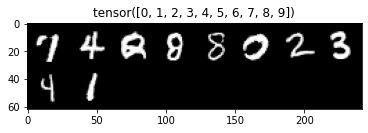

In [166]:
# z = test_nosie
# c = test_code
# c_label = torch.max(test_code[:, :-2], 1)[1].view(-1, )

# def pridict1():
#     G.eval()
#     with torch.no_grad():
#         fake = G(z, c)
#         fake_image_grid = vutils.make_grid(fake[:].detach().cpu(),
#                                            padding=2,
#                                            normalize=True)
#         plt.title(c_label[:])
#         plt.imshow(np.transpose(fake_image_grid, [1, 2, 0]))


# pridict1()